# Bayesian Network Example with `pgmpy`, `pomegranate`, and `bnlearn`

Starting with `pgmpy` (probabilistic graphical models in python), we'll do some simple Bayesian Networks. 

This demo uses the `TabularCPD` object to create tables of Conditional Probability Distributions (CPD). Everything should be self-explanatory and well-documented in the help, but here's some that I didn't understand at first glance:
* `variable_card` = variable cardinality, i.e. the number of states the variable can take
* `evidence` = list of variable *names*
* `evidence_card` = cardinality of the evidence, should be a list

>In pgmpy we define the network structure and the CPDs (conditional probability distributions) separately and then associate them with the structure. Here’s an example for defining the above model:

In [1]:
import pandas as pd

In [2]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

## Example 1

This example comes from the excellent and short course by [Phillip Loick on Bayesian Statistics (Udemy)](https://www.udemy.com/course/bayesian-statistics/):

![fig2.png](fig2.png)

This is a fun model that models whether or not two people (John and Kate) will run based on the temperature and whether or not these two will meet. 

In [3]:
# 1. Instantiate the model with node edges as a list
model = BayesianNetwork([('T', 'J'), ('T', 'K'), ('J', 'M'), ('K', 'M')])

# 2. Define the distributions
cpd_t = TabularCPD(variable='T', variable_card=2, values=[[0.4], [0.6]], state_names={'T':['low', 'high']})
cpd_j = TabularCPD(variable='J', variable_card=2, 
                   values=[[0.5, 0.7], 
                           [0.5, 0.3]], 
                   evidence=['T'],
                   evidence_card=[2],
                   state_names={'J':['yes', 'no'],
                               'T':['low', 'high']})
cpd_k = TabularCPD(variable='K', variable_card=2, 
                   values=[[0.4, 0.75], 
                           [0.6, 0.25]], 
                   evidence=['T'],
                   evidence_card=[2],
                   state_names={'K':['yes', 'no'],
                               'T':['low', 'high']})
cpd_m = TabularCPD(variable='M', variable_card = 2,
                  values=[[.5, 0, 0, 0],
                         [.5, 1, 1, 1]],
                  evidence=['J', 'K'],
                  evidence_card=[2, 2],
                  state_names={'M': ['yes', 'no'],
                              'J': ['yes', 'no'],
                              'K': ['yes', 'no']})

# 3. Add CPDs to the model
model.add_cpds(cpd_t, cpd_j, cpd_k, cpd_m)
# 4. Check the model validity (i.e. probabilities all sum to 1)
model.check_model()

True

Let's doubleclick into the 'M' node because the evidence table looks **different** than the conditional probability table that was in the first figure:

In [4]:
# Printing a CPD with it's state names defined.
print(model.get_cpds('M'))

+--------+--------+--------+--------+-------+
| J      | J(yes) | J(yes) | J(no)  | J(no) |
+--------+--------+--------+--------+-------+
| K      | K(yes) | K(no)  | K(yes) | K(no) |
+--------+--------+--------+--------+-------+
| M(yes) | 0.5    | 0.0    | 0.0    | 0.0   |
+--------+--------+--------+--------+-------+
| M(no)  | 0.5    | 1.0    | 1.0    | 1.0   |
+--------+--------+--------+--------+-------+


This is because `pgmpy` expects you to have the `variable` states on rows and then like a multi-index of `evidence` on columns. Recall the `evidence` and `evidence_card` items we called out earlier as `['J', 'K']` in the `TabularCPD` call for variable `M`, so the columns show up in the order of the `evidence` and the `state_names` for each.

## Inference with Variable Elimination

Let’s take an example of inference using Variable Elimination in `pgmpy`. Here we'll use our model to compute the probability distribution that the two meet, and `pgmpy` will make a pretty table: 

In other words, what is the probability that they meet $P(M)=?$

In [5]:
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)
g_dist = infer.query(['M'])
print(g_dist)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

+--------+----------+
| M      |   phi(M) |
+========+==========+
| M(yes) |   0.1975 |
+--------+----------+
| M(no)  |   0.8025 |
+--------+----------+


You can infer conditional probabilities by adding a new term called `evidence`. Here we ask what's the probability that John goes for a run, given that they don't meet?

i.e.: $P(J|M=\text{no})$

In [6]:
print(infer.query(['J'], evidence={'M': 'no'}))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+--------+----------+
| J      |   phi(J) |
+========+==========+
| J(yes) |   0.5265 |
+--------+----------+
| J(no)  |   0.4735 |
+--------+----------+


What is $P(M=\text{yes}|T=\text{high})?$

In [7]:
print(infer.query(['M'], evidence={'T': 'high'}))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+--------+----------+
| M      |   phi(M) |
+========+==========+
| M(yes) |   0.2625 |
+--------+----------+
| M(no)  |   0.7375 |
+--------+----------+


What is $P(J|K)?$

In [8]:
print(infer.query(['J'], evidence={'K': 'yes'}))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+--------+----------+
| J      |   phi(J) |
+========+==========+
| J(yes) |   0.6475 |
+--------+----------+
| J(no)  |   0.3525 |
+--------+----------+


## Example 2

Also from the same Udemy course, there's another example that models medical device sales and whether or not a customer is going to cancel an order.

![fig3.png](fig3.png)

Once again, we follow the earlier pattern:

In [9]:
model = BayesianNetwork([('T', 'N'), ('R', 'N'), ('N', 'U'), ('U', 'P'), ('U', 'C'), ('P', 'C')])

T = TabularCPD(variable='T', variable_card=2, values=[[0.25], [0.75]], state_names={'T':['Hospital', 'DO']})
R = TabularCPD(variable='R', variable_card=2, values=[[0.55], [0.45]], state_names={'R':['North', 'South']})
N = TabularCPD(variable='N', variable_card=2,
                  values=[[.9, .75, .8, .6],
                         [.1, .25, .2, .4]],
                  evidence=['T', 'R'],
                  evidence_card=[2, 2],
                  state_names={'N': ['1', '≥2'],
                              'T': ['Hospital', 'DO'],
                              'R': ['North', 'South']})
U = TabularCPD(variable='U', variable_card=2,
              values=[[.5, .3],
                     [.5, .7]],
              evidence=['N'],
              evidence_card=[2],
              state_names={'U': ['low', 'high'],
                          'N': ['1', '≥2']})
P = TabularCPD(variable='P', variable_card=2,
              values=[[.3, .6],
                     [.7, .4]],
              evidence=['U'],
              evidence_card=[2],
              state_names={'P': ['yes', 'no'],
                          'U': ['low', 'high']})
C = TabularCPD(variable='C', variable_card=2,
                  values=[[.4, .2, .25, .1],
                         [.6, .8, .75, .9]],
                  evidence=['U', 'P'],
                  evidence_card=[2, 2],
                  state_names={'C': ['yes', 'no'],
                              'U': ['low', 'high'],
                              'P': ['yes', 'no']})

model.add_cpds(T, R, N, U, P, C)
model.check_model()

True

In [10]:
print(model.get_cpds('C'))

+--------+--------+--------+---------+---------+
| U      | U(low) | U(low) | U(high) | U(high) |
+--------+--------+--------+---------+---------+
| P      | P(yes) | P(no)  | P(yes)  | P(no)   |
+--------+--------+--------+---------+---------+
| C(yes) | 0.4    | 0.2    | 0.25    | 0.1     |
+--------+--------+--------+---------+---------+
| C(no)  | 0.6    | 0.8    | 0.75    | 0.9     |
+--------+--------+--------+---------+---------+


### Independence

Is customer cancellation independent of customer type?

In [11]:
# Getting all the local independencies in the network.
model.local_independencies(['C', 'T'])

(C ⟂ R, T, N | P, U)
(T ⟂ R)

Type is not independent of cancellation

Next, is customer cancellation independent of customer type given usage?

Type is indeed conditionally independent of customer cancellation given usage

### Inference

In [12]:
infer = VariableElimination(model)

Find probability that a customer cancels given that it's in the north region:

In [13]:
print(infer.query(['C'], evidence={'R': 'North'}))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+--------+----------+
| C      |   phi(C) |
+========+==========+
| C(yes) |   0.2226 |
+--------+----------+
| C(no)  |   0.7775 |
+--------+----------+


Find the probability that a customer is a hospital given that it is cancelled:

In [14]:
print(infer.query(['T'], evidence={'C': 'yes'}))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

+-------------+----------+
| T           |   phi(T) |
+=============+==========+
| T(Hospital) |   0.2515 |
+-------------+----------+
| T(DO)       |   0.7485 |
+-------------+----------+


# Pomegranate

An alternative to `pgmpy` is the newer `pomegranate` library. For bayesian networks, `pomegranate` offers some advantages like a built in plotting function, but interpreting the results isn't as fully developed. Furthermore, as of this writing (v 0.14.7) `pomegranate` can only support discrete Bayesian networks (which is fine because that's what our toy example is).

In [15]:
import pomegranate as pm

Unlike `pgmpy`, in `pomegranate` we need to specify the probabilities that John/Kate run using a `DiscreteDistribution` object instead of a conditional probability table. Luckily, `pomegranate` offers a few nice helper functions to make working with distributions faily simple:

In [16]:
# Initialize a distribution and specify parameters
T = pm.DiscreteDistribution({"low":0.4, "high":0.6})
T

{
    "class" : "Distribution",
    "dtype" : "str",
    "name" : "DiscreteDistribution",
    "parameters" : [
        {
            "low" : 0.4,
            "high" : 0.6
        }
    ],
    "frozen" : false
}

We see this instantiated a `Distribution` object with the named `parameters` for each state of the discrete distribution. 

`pomegranate` has built in plotting functions. Given this very simple distribution, we can plot the pdf with the `.plot()` method:

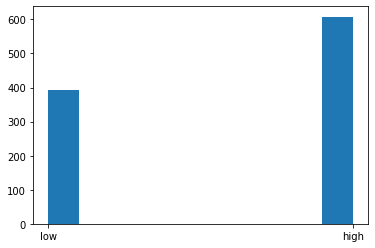

In [17]:
T.plot()

A few other useful methods:

* `sample(n)`: draw `n` samples from the distribution
* `probability(X)`: predict the probability of X under this distribution

In [18]:
T.sample(3)

array(['low', 'high', 'high'], dtype='<U4')

In [19]:
T.probability('high')

0.6

### Conditional Probability Tables

The probability table from the first figure will need to be respecified to a 'long' format.

| T | J | probability |
| ---| ---| ----|
| low | yes | 50%|
| low | no | 50%|
| high | yes | 70%|
| high | no | 30%|

The `ConditionalProbabilityTable` takes an argument `table` which is a list of lists, with each inner list is a row. A second argument `parents` defines the parent distributions upon which this table depends.

In [20]:
# Create the `John` variable as a conditional probability table
J = pm.ConditionalProbabilityTable(
    table=[['low', 'yes', 0.5],
           ['low', 'no', 0.5],
           ['high', 'yes', 0.7],
           ['high', 'no', 0.3]], 
    parents=[T])

So the pattern for the `ConditionalProbabilityTable` would look like:

| parent1 | variable | probability | 
| --- | --- | --- |
| parent1_state1 | variable_state1 | |
| parent1_state1 | variable_state2 | |
| etc | etc | |

Let's add some more nodes and build a model to examine how we can do inference.

The procedure for creating the network is as follows:

1. Instantiate the `BayesianNetwork` model
2. Define the distributions you want to use
3. Create Node objects with these distributions and add them to the model
4. Add edges to the model with the `.add_edge(edge1, edge2)` method
5. Bake the model using the `.bake()` method

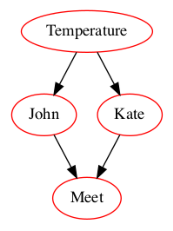

In [21]:
# 1. Instantiate the BayesianNetwork model
model = pm.BayesianNetwork("Calculating Posterior")

# 2. Add more distributions
K = pm.ConditionalProbabilityTable(
    table=[['low', 'yes', 0.4],
           ['low', 'no', 0.6],
           ['high', 'yes', 0.75],
           ['high', 'no', 0.25]], parents=[T])
M = pm.ConditionalProbabilityTable(
    table=[['yes', 'yes', 'yes', 0.5],
           ['yes', 'yes', 'no', 0.5],
           ['yes', 'no', 'yes', 0],
           ['yes', 'no', 'no', 1],
           ['no', 'yes', 'yes', 0],
           ['no', 'yes', 'no', 1],
           ['no', 'no', 'yes', 0],
           ['no', 'no', 'no', 1]], parents=[J, K])

# 3. Define nodes in our network that follow these distributions
n0 = pm.Node(T, name='Temperature')
n1 = pm.Node(J, name='John')
n2 = pm.Node(K, name='Kate')
n3 = pm.Node(M, name='Meet')
model.add_states(n0, n1, n2, n3)

# 4. Define the Edges for each Node in our model
model.add_edge(n0, n1)
model.add_edge(n0, n2)
model.add_edge(n1, n3)
model.add_edge(n2, n3)

# 5. Bake the model
model.bake()

# Optional: Plot
model.plot()

I like the ability to plot (requires `matplotlib` and `pygraphviz`). Great feature!

## Inference

We would like to do a simple inference - what's the probability that they meet?

In other words, what is the probability that they meet $P(M=\text{'yes'})$?

In `pomegranate` you can do this by specifying all of the probabilities like such:

In [22]:
model.probability([['high', 'yes', 'yes', 'yes'],
                  ['high', 'yes', 'no', 'yes'],
                  ['high', 'no', 'yes', 'yes'],                  
                  ['high', 'no', 'no', 'yes'],
                  ['low', 'yes', 'yes', 'yes'],
                  ['low', 'yes', 'no', 'yes'],
                  ['low', 'no', 'yes', 'yes'],                  
                  ['low', 'no', 'no', 'yes'],                   
                  ]).sum()

0.19749999999999995

There is also a `marginal` method to get the marginal distribution of each of the variables:

In [23]:
model.marginal().shape

(4,)

In [24]:
model.marginal()[3]

{
    "class" : "Distribution",
    "dtype" : "str",
    "name" : "DiscreteDistribution",
    "parameters" : [
        {
            "yes" : 0.18910000000000005,
            "no" : 0.8109000000000001
        }
    ],
    "frozen" : false
}

Interesting that the marginal distribution is different than what I had calculated manually! There must be a bug in my model somewhere...

## Impressions

It looks like it's still too early for `pomegranate` when it comes to Bayesian Networks when compared to `pgmpy`. It felt still very much WIP to use `pomegranate` with docstrings and help/error messages seem incomplete, while `pgmpy` has extensive documentation. 

# Classic Disease Model with `pgmpy` and `bnlearn`

For this next example, we'll use the classic Disease model: 

Let's say that there's a disease that affects 2% of the population, and you have a 95% chance of testing positive (correctly) if you have the disease, and a 10% change of testing positive if you don't have the disease. What's the probability that you have the disease, given that you tested positive?

The Conditional Probability Table would look like:

<table>
<thead>
  <tr>
    <th colspan="2" rowspan="2"></th>
    <th colspan="2">Test Result</th>
  </tr>
  <tr>
    <th>Positive</th>
    <th>Negative</th>
  </tr>
</thead>
<tbody>
  <tr>
	  <td rowspan="2"><b>Disease</b></td>
	  <td><b>Yes</b></td>
    <td>0.95</td>
    <td>.05</td>
  </tr>
  <tr>
	  <td><b>No</b></td>
    <td>0.90</td>
    <td>0.1</td>
  </tr>
</tbody>
</table>

An alternative to `pgmpy` is to use `bnlearn` which extends some of the features from `pgmpy` and just...does more. It can even use `pgmpy` objects like `TabularCPD`, but it looks like there are lot more convenience functions included in it to help learn from data (including the ability to handle dataframes).

In [25]:
# Import the library
import bnlearn as bn

`bnlearn.make_DAG` takes in an argument `DAG` which should be your list of edges, and a `CPD` argument for your conditional probability distributions that were created with `pgmpy.TabularCPD`. 

For fun, we'll create this model with two tests ($T1$, $T2$) so we can look at statistics if you get multiple tests.

In [26]:
# Define the network structure
edges = [('D', 'T1'), ('D', 'T2')]

d = TabularCPD(variable='D', variable_card=2, values=[[0.02], [0.98]],
                  state_names={'D':['yes', 'no']})
t1 = TabularCPD(variable='T1', variable_card=2, 
                  values=[[0.95, 0.1],
                         [0.05, 0.9]],
                  evidence=['D'],
                  evidence_card=[2],
                  state_names={'D':['yes', 'no'],
                              'T1':['positive', 'negative']})
t2 = TabularCPD(variable='T2', variable_card=2, 
                  values=[[0.95, 0.1],
                         [0.05, 0.9]],
                  evidence=['D'],
                  evidence_card=[2],
                  state_names={'D':['yes', 'no'],
                              'T2':['positive', 'negative']})

# Make the actual Bayesian DAG with the previously defined CPD's 
model = bn.make_DAG(DAG=edges, CPD=[d, t1, t2])

[bnlearn] >bayes DAG created.
[bnlearn] >Add CPD: D
[bnlearn] >Add CPD: T1
[bnlearn] >Add CPD: T2
[bnlearn] >Checking CPDs..
[bnlearn] >Check for DAG structure. Correct: True


[bnlearn]> Set node properties.
[bnlearn]> Set edge properties.
[bnlearn] >Plot based on Bayesian model


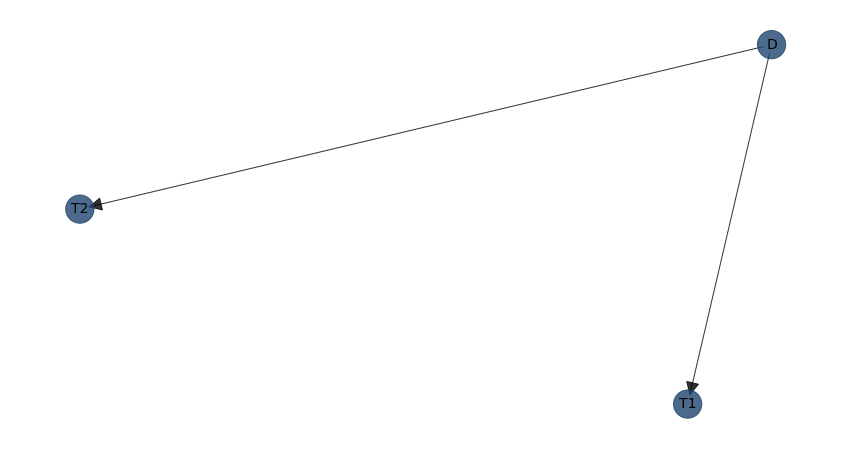

In [27]:
# Set interactive=False for web publishing
# If you have `pyviz` installed you can get an interactive graph!
bn.plot(model, title='Disease Test', interactive=False);

There's also a handy `print_CPD` method that lets you pretty print all the CPD's.

In [28]:
bn.print_CPD(model)

CPD of D:
+--------+------+
| D(yes) | 0.02 |
+--------+------+
| D(no)  | 0.98 |
+--------+------+
CPD of T1:
+--------------+--------+-------+
| D            | D(yes) | D(no) |
+--------------+--------+-------+
| T1(positive) | 0.95   | 0.1   |
+--------------+--------+-------+
| T1(negative) | 0.05   | 0.9   |
+--------------+--------+-------+
CPD of T2:
+--------------+--------+-------+
| D            | D(yes) | D(no) |
+--------------+--------+-------+
| T2(positive) | 0.95   | 0.1   |
+--------------+--------+-------+
| T2(negative) | 0.05   | 0.9   |
+--------------+--------+-------+
[bnlearn] >Independencies:
(T2 ⟂ T1 | D)
(T1 ⟂ T2 | D)
[bnlearn] >Nodes: ['D', 'T1', 'T2']
[bnlearn] >Edges: [('D', 'T1'), ('D', 'T2')]


### Inference

You can also use `bnlearn.inference` to perform inference using Variable Elimination, similar to what we saw in `pgmpy`:

In [29]:
bn.inference.fit(model, variables=['D'], evidence={'T1':'positive'})

[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+----+-----+----------+
|    |   D |        p |
+====+=====+==========+
|  0 |   0 | 0.162393 |
+----+-----+----------+
|  1 |   1 | 0.837607 |
+----+-----+----------+


<DiscreteFactor representing phi(D:2) at 0x7f91c51afaf0>

*Note: Interesting that it doesn't show the 'state' names here, so the above result is 'yes' for 0 and 'no' for 1 because that's the order in which we defined the states.*

Surprisingly, with the given assumptions, with a single positive test there would only be a 16% probability that you'd have the disease! What's it look like if you had two positive tests?

In [30]:
bn.inference.fit(model, variables=['D'], evidence={'T1':'positive', 'T2':'positive'})

[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+----+-----+----------+
|    |   D |        p |
+====+=====+==========+
|  0 |   0 | 0.648115 |
+----+-----+----------+
|  1 |   1 | 0.351885 |
+----+-----+----------+


<DiscreteFactor representing phi(D:2) at 0x7f91c51b2880>

So we see here that there's a 65% probability of having this disease after testing positive *twice*. A pretty dramatic improvement from the 16% earlier. But still, this is really low!

## What about a real-world example with Covid testing?

The above example uses numbers to help surprise the learner about how counterintuitive statistics can be. But should we be skeptical of *any* test, especially in 2022?

If we change the prevalence and sensitivity/specificity to, say, real-world numbers for Covid-19, the numbers become more reassuring.

We can check real world numbers thanks to resources like:
* [FDA Emergency Use Authorization statistics for Covid Tests](https://www.fda.gov/medical-devices/coronavirus-disease-2019-covid-19-emergency-use-authorizations-medical-devices/eua-authorized-serology-test-performance)
* [CDC Covid Data Tracker for disease prevalence](https://covid.cdc.gov/covid-data-tracker/#datatracker-home)

### Estimating disease prevalence

You can use the [CDC Covid Tracker](https://covid.cdc.gov/covid-data-tracker/#datatracker-home) to get a sense of positive cases per 100K people. Let's pull the data for Multnomah County, host of the fine city of Portland, Oregon:

|![covid_prevalence](covid_prevalence.png)|
|:---:|
|Source: [CDC Covid Tracker](https://covid.cdc.gov/covid-data-tracker/#datatracker-home)|


Let's say that this published rate only captures 1/4 of actual cases, due to folks not reporting (i.e. people testing at home, people who are asymptomatic and don't get tested, etc), then the true prevalence would be about 2.6%:

In [31]:
(646.86 * 4)/100000

0.025874400000000002

### FDA data on covid test performance

You can also get sensitivity and specificity data on the covid tests that the FDA approved for emergency use in the early days of the pandemic: 

Here we'll use data on the Abbott AdviseDx SARS-CoV-2 IgG II (Alinity), which has a sensitivity of 98.1% (51/52), specificity of 99.6% (2000/2008). Because of the way that we've formulated this problem, we can substitute the following:

$$
\begin{aligned}
\text{Sensitivity} &= P(D=\text{yes}|T=\text{'positive'}) = 51/52 = 98.0769\%\\
\text{Specificity} &= P(D=\text{no}|T=\text{'negative'}) = 2000/2008 = 99.6016\%\\
\end{aligned}
$$

Or as a conditional probability table:

<table>
<thead>
  <tr>
    <th colspan="2" rowspan="2"></th>
    <th colspan="2">Test Result</th>
  </tr>
  <tr>
    <th>Positive</th>
    <th>Negative</th>
  </tr>
</thead>
<tbody>
  <tr>
	  <td rowspan="2"><b>Disease</b></td>
	  <td><b>Yes</b></td>
    <td>0.981</td>
    <td>0.019</td>
  </tr>
  <tr>
	  <td><b>No</b></td>
    <td>0.004</td>
    <td>0.996</td>
  </tr>
</tbody>
</table>

For convenience, from here on out we'll redefine this as a function:

In [32]:
def disease_test(prevalence, sens, spec):
    """
    Parameters
    ----------
    prevalence : float
        Estimated percent of population that has the disease
    sens : float
        Sensitivity, or true positive rate
    spec : float
        Specificity, or true negative rate
    """
    edges = [('D', 'T1'), ('D', 'T2')]

    d = TabularCPD(variable='D', variable_card=2, values=[[prevalence], [1-prevalence]],
                      state_names={'D':['yes', 'no']})
    t1 = TabularCPD(variable='T1', variable_card=2, 
                      values=[[sens, 1-spec],
                             [1-sens, spec]],
                      evidence=['D'],
                      evidence_card=[2],
                      state_names={'D':['yes', 'no'],
                                  'T1':['positive', 'negative']})
    t2 = TabularCPD(variable='T2', variable_card=2, 
                      values=[[sens, 1-spec],
                             [1-sens, spec]],
                      evidence=['D'],
                      evidence_card=[2],
                      state_names={'D':['yes', 'no'],
                                  'T2':['positive', 'negative']})
    # Make the actual Bayesian DAG with the previously defined CPD's 
    model = bn.make_DAG(DAG=edges, CPD=[d, t1, t2], verbose=1) # quiet those messages!
    return model

In [33]:
model = disease_test(0.026, sens=51/52, spec=2000/2008)
bn.inference.fit(model, variables=['D'], evidence={'T1':'positive'})

[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+----+-----+----------+
|    |   D |        p |
+====+=====+==========+
|  0 |   0 | 0.867923 |
+----+-----+----------+
|  1 |   1 | 0.132077 |
+----+-----+----------+


<DiscreteFactor representing phi(D:2) at 0x7f91c54f2be0>

Reassuringly, the probability of having the disease is about 87%, after having tested positive with this test (and assuming prevalence of 2.6%).

In [34]:
bn.inference.fit(model, variables=['D'], evidence={'T1':'positive', 'T2':'positive'})

[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+----+-----+-------------+
|    |   D |           p |
+====+=====+=============+
|  0 |   0 | 0.999382    |
+----+-----+-------------+
|  1 |   1 | 0.000617783 |
+----+-----+-------------+


<DiscreteFactor representing phi(D:2) at 0x7f91c54e0640>

And after 2 tests, the probability rises to 99.9%. Not bad, right?

Now, let's take a quick look with a rapid at-home test like the Abbot BinaxNOW test. There seems to be some conflicting data on this (i.e. the results are better if you're symptomatic), but we can try to use some available overall numbers. Skimming the results of Table 2 from [this Nov 2020 study](https://www.cdc.gov/mmwr/volumes/70/wr/mm7003e3.htm) gives us a Sensitivity of 52.5% and Specificity of 99.9%:

|<br>|
|:---:|
|![binax_sens_spec](binax_sens_spec.png)|
| From: [Prince-Guerra JL, Almendares O, Nolen LD, et al. Evaluation of Abbott BinaxNOW Rapid Antigen Test for SARS-CoV-2 Infection at Two Community-Based Testing Sites — Pima County, Arizona, November 3–17, 2020. MMWR Morb Mortal Wkly Rep 2021](https://www.cdc.gov/mmwr/volumes/70/wr/mm7003e3.htm)|

In [35]:
model = disease_test(0.026, sens=0.525, spec=0.999)
bn.inference.fit(model, variables=['D'], evidence={'T1':'positive'})

[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+----+-----+-----------+
|    |   D |         p |
+====+=====+===========+
|  0 |   0 | 0.933397  |
+----+-----+-----------+
|  1 |   1 | 0.0666028 |
+----+-----+-----------+


<DiscreteFactor representing phi(D:2) at 0x7f91c5515610>

So that's *quite* good, considering the study found that sensitivity was much higher among symptomatic patients. We can also take a look if you take two tests:

In [36]:
bn.inference.fit(model, variables=['D'], evidence={'T1':'positive', 'T2':'positive'})

[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+----+-----+-------------+
|    |   D |           p |
+====+=====+=============+
|  0 |   0 | 0.999864    |
+----+-----+-------------+
|  1 |   1 | 0.000135896 |
+----+-----+-------------+


<DiscreteFactor representing phi(D:2) at 0x7f91c554aac0>

And now there's near certainty with two tests. What if you had one test positive and another negative, out of curiosity?

In [37]:
bn.inference.fit(model, variables=['D'], evidence={'T1':'positive', 'T2':'negative'})

[bnlearn] >Variable Elimination..


0it [00:00, ?it/s]

0it [00:00, ?it/s]

+----+-----+----------+
|    |   D |        p |
+====+=====+==========+
|  0 |   0 | 0.869511 |
+----+-----+----------+
|  1 |   1 | 0.130489 |
+----+-----+----------+


<DiscreteFactor representing phi(D:2) at 0x7f91c5563760>

## References

* [Phillip Loick on Bayesian Statistics (Udemy)](https://www.udemy.com/course/bayesian-statistics/)
* `bnlearn`: https://github.com/erdogant/bnlearn, much newer and very promising 
* `pymc` thread on bayes nets: https://discourse.pymc.io/t/bayes-nets-belief-networks-and-pymc/5150/8
* [FDA Emergency Use Authorization statistics for Covid Tests](https://www.fda.gov/medical-devices/coronavirus-disease-2019-covid-19-emergency-use-authorizations-medical-devices/eua-authorized-serology-test-performance)
* [CDC Covid Data Tracker for disease prevalence](https://covid.cdc.gov/covid-data-tracker/#datatracker-home)
* [Prince-Guerra JL, Almendares O, Nolen LD, et al. Evaluation of Abbott BinaxNOW Rapid Antigen Test for SARS-CoV-2 Infection at Two Community-Based Testing Sites — Pima County, Arizona, November 3–17, 2020. MMWR Morb Mortal Wkly Rep 2021](https://www.cdc.gov/mmwr/volumes/70/wr/mm7003e3.htm)